导入必要的库

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


数据加载预处理

In [43]:
transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
data=datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
data_loader=DataLoader(dataset=data,batch_size=64,shuffle=True)

Files already downloaded and verified


定义生成器和判别器

In [44]:
# 检查CUDA（GPU支持）是否可用
cuda_available = torch.cuda.is_available()
print("CUDA Available:", cuda_available)
device = torch.device("cuda" if cuda_available else "cpu")


class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self,input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
                    )
    def forward(self,input):
        return self.main(input).view(-1,1)
    


CUDA Available: True


初始化模型，损失函数和优化器

In [45]:
generator=Generator()
generator.to(device)
discriminator=Discriminator()
discriminator.to(device)

#损失函数
loss_function=nn.BCELoss()

#优化器
optimizer_g=optim.Adam(generator.parameters(),lr=0.0002)
optimizer_d=optim.Adam(discriminator.parameters(),lr=0.0002)

开始训练

In [50]:
epochs = 50
for epoch in range(epochs):
    for i, (images, _) in enumerate(data_loader):
        # 训练判别器
        discriminator.zero_grad()
        real_data = images.to(device)
        # 生成真实图像标签和假的图像标签
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        # 训练判别器去识别真实图像
        outputs = discriminator(real_data)
        real_loss = loss_function(outputs, real_labels)
        real_score = outputs

        # 训练判别器去识别假的图像
        noise = torch.randn(images.size(0), 100, 1, 1).to(device)
        fake_data = generator(noise)
        outputs = discriminator(fake_data.detach())
        fake_loss = loss_function(outputs, fake_labels)
        fake_score = outputs

        # 总的判别器损失
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()

        # 训练生成器，生成假的图像，并且训练判别器去识别假的图像，如果生成器生成的图像判别器认为是假的图像，
        #那么对应真实标签去计算损失就一定很高，反之如果判别器认为是真的图像，那么对应真的标签去计算损失就会很低
        generator.zero_grad()
        # 生成器试图欺骗判别器，因此使用真实标签
        outputs = discriminator(fake_data)
        g_loss = loss_function(outputs, real_labels)

        g_loss.backward()
        optimizer_g.step()
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, '
          'D(x): {:.2f}, D(G(z)): {:.2f}'.format(epoch, epochs, d_loss.item(), g_loss.item(),
                                                  real_score.mean().item(), fake_score.mean().item()))


Epoch [0/50], d_loss: 0.3269, g_loss: 7.9943, D(x): 0.81, D(G(z)): 0.01
Epoch [1/50], d_loss: 0.1925, g_loss: 7.4819, D(x): 0.87, D(G(z)): 0.02
Epoch [2/50], d_loss: 0.0093, g_loss: 12.5182, D(x): 0.99, D(G(z)): 0.00
Epoch [3/50], d_loss: 0.6271, g_loss: 5.5797, D(x): 0.71, D(G(z)): 0.14
Epoch [4/50], d_loss: 0.4105, g_loss: 6.1599, D(x): 0.77, D(G(z)): 0.01
Epoch [5/50], d_loss: 0.0126, g_loss: 7.5947, D(x): 0.99, D(G(z)): 0.01
Epoch [6/50], d_loss: 0.3732, g_loss: 6.9966, D(x): 0.98, D(G(z)): 0.13
Epoch [7/50], d_loss: 0.2998, g_loss: 7.4090, D(x): 0.82, D(G(z)): 0.02
Epoch [8/50], d_loss: 0.0703, g_loss: 6.3138, D(x): 1.00, D(G(z)): 0.06
Epoch [9/50], d_loss: 0.5814, g_loss: 9.0370, D(x): 0.75, D(G(z)): 0.03
Epoch [10/50], d_loss: 0.0203, g_loss: 10.6561, D(x): 0.98, D(G(z)): 0.00


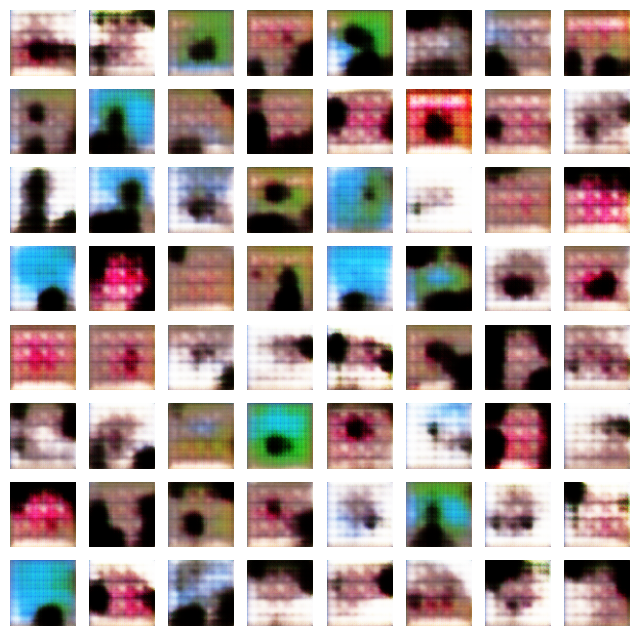

In [49]:
with torch.no_grad():
    fixed_noise = torch.randn(64, 100, 1, 1).to(device)
    fake_images = generator(fixed_noise).cpu()

# 将图像数据范围从[-1, 1]调整到[0, 1]
fake_images = (fake_images + 1) / 2

# 显示图片
fig = plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i + 1)

    plt.imshow(np.transpose(fake_images[i], (1, 2, 0)))
    

    plt.axis('off')
plt.show()



In [ ]:
import torch
import torch.nn as nn

# 你的鉴别器类定义在这里

# 创建鉴别器实例
model = Discriminator()

# 创建一个示例张量（例如，一个具有3个通道，64x64像素的图像）
# 这里的批量大小设置为1
example_input = torch.randn(1, 3, 64, 64)

# 打印每一层之后的输出尺寸
current = example_input
for layer in model.main:
    current = layer(current)
    print(current.size())


torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 128, 16, 16])
torch.Size([1, 128, 16, 16])
torch.Size([1, 128, 16, 16])
torch.Size([1, 128, 16, 16])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 8, 8])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 1, 1, 1])
torch.Size([1, 1, 1, 1])
